In [3]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [5]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

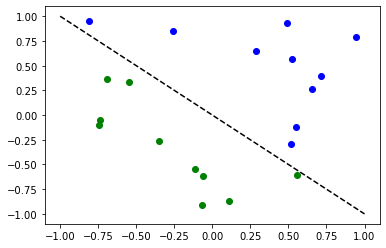

In [6]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for CircuitQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for OplowQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [7]:
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)
print(qnn1.operator)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐»
  q_0: ┤0                         ├»
       │  ZZFeatureMap(x[0],x[1]) │»
  q_1: ┤1                         ├»
       └──────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                         ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
  «q_1: ┤1                                                         ├
  «     └──────────────────────────────────────────────────────────┘
  )
])
Initial weights:  [-0.01256962  0.06653564  0.04005302 -0.03752667  0.06645196  0.06095287
 -0.02250432 -0.04233438]


In [12]:
# Test with a single input
model1(X_[0])

tensor([-0.3285], grad_fn=<_TorchNNFunctionBackward>)

In [13]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

25.535646438598633
22.696760177612305
20.039228439331055
19.687908172607422
19.267208099365234
19.025373458862305
18.154708862304688
17.337854385375977
19.082578659057617
17.073287963867188
16.21839141845703
14.992582321166992
14.929339408874512
14.914533615112305
14.907636642456055
14.902364730834961
14.902134895324707
14.90211009979248
14.902111053466797


tensor(25.5356, grad_fn=<MseLossBackward0>)

Accuracy: 0.8


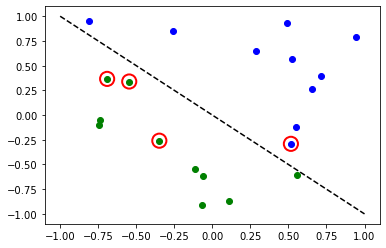

In [14]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

# QGAN :)

In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf

In [2]:
dev = qml.device('cirq.simulator', wires=3)

In [3]:
# generate distribution
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

In [4]:
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)


def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

In [9]:
@qml.qnode(dev, interface="tf")
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev, interface="tf")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

In [11]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

In [12]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

2022-04-11 18:03:29.751676: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
opt = tf.keras.optimizers.SGD(0.4)

In [14]:
cost = lambda: disc_cost(disc_weights)

for step in range(50):
    opt.minimize(cost, disc_weights)
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.05727693438529968
Step 5: cost = -0.2634810581803322
Step 10: cost = -0.42739150300621986
Step 15: cost = -0.4726157411932945
Step 20: cost = -0.48406897485256195
Step 25: cost = -0.48946385085582733
Step 30: cost = -0.4928187355399132
Step 35: cost = -0.49494922906160355
Step 40: cost = -0.4962702915072441
Step 45: cost = -0.4970718249678612


In [15]:
print("Prob(real classified as real): ", prob_real_true(disc_weights).numpy())

Prob(real classified as real):  0.9985871016979218


In [16]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.5011128559708595


In [17]:
cost = lambda: gen_cost(gen_weights)

for step in range(50):
    opt.minimize(cost, gen_weights)
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.5833386555314064
Step 5: cost = -0.8915733397006989
Step 10: cost = -0.9784241914749146
Step 15: cost = -0.9946482479572296
Step 20: cost = -0.9984995126724243
Step 25: cost = -0.9995638430118561
Step 30: cost = -0.9998717308044434
Step 35: cost = -0.9999619722366333
Step 40: cost = -0.9999887645244598
Step 45: cost = -0.9999964833259583


In [18]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.9999986886978149


In [19]:
print("Discriminator cost: ", disc_cost(disc_weights).numpy())

Discriminator cost:  0.0014115869998931885


In [20]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_generator = qml.map(generator, obs, dev, interface="tf")

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights)))

Real Bloch vector: [-0.21694186  0.45048442 -0.86602521]
Generator Bloch vector: [-0.28404659  0.41893226 -0.86244404]
